In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
# import seaborn as sns

from gglm.glm.mmdglm import MMDGLM
# from gglm.cnncritic import MMDCritic
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from kernel.fun import KernelFun
from kernel.rect import KernelRect

%load_ext autoreload
%autoreload 2

In [2]:
# npz = np.load('./fr_mismatch.npz')
# t, stim, mask_spikes_te, u_spk_mean_te, mask_spikes_fr, u_spk_mean_fr  = npz['t'], npz['stim'], npz['mask_spikes_te'], npz['u_spk_mean_te'], npz['mask_spikes_fr'], npz['u_spk_mean_fr']

npz = np.load('/home/diego/python/generative-glm/cool_stuff/diverging_fr.npz')
t, r_te, r_fr, mask_spikes_te, mask_spikes_fr  = npz['t'], npz['r_te'], npz['r_fr'], npz['mask_spikes_te'], npz['mask_spikes_fr']

u_te, u_fr = npz['u_te'], npz['u_fr']

u0_ml, eta_tau, eta_vals_ml = npz['glm_u0'], npz['glm_eta_tau'], npz['glm_eta_coefs']

dt = t[1]

n_batch_te = mask_spikes_te.shape[1]
n_batch_fr = mask_spikes_fr.shape[1]

st_te = SpikeTrain(t, mask_spikes_te)
st_fr = SpikeTrain(t, mask_spikes_fr)

mask_spikes = np.concatenate((mask_spikes_te, mask_spikes_fr), axis=1)
n_spikes_te = np.sum(mask_spikes_te, 0)
n_spikes_fr = np.sum(mask_spikes_fr, 0)
mask_spikes_te = torch.from_numpy(mask_spikes_te)
mask_spikes = torch.from_numpy(mask_spikes).double()
# y = np.concatenate((np.ones(mask_spikes_te.shape[1]), np.zeros(mask_spikes_fr.shape[1])))
y = torch.cat((torch.ones(n_batch_te), torch.zeros(n_batch_fr))).double()
u = torch.from_numpy(np.concatenate((u_te, u_fr), axis=1)).double()
r = torch.from_numpy(np.concatenate((r_te, r_fr), axis=1)).double()

# x = torch.stack((mask_spikes.T, u.T), dim=1)
# x = u.T[:, None, :].clone()

ms = 1

In [3]:
def distance(r, mask_spikes, y):
    r_te, r_fr = r[:, y == 1], r[:, y == 0]
    n_batch_te, n_batch_fr = r_te.shape[1], r_fr.shape[1]
    r_sum_te, r_sum_fr = torch.sum(r_te, 1), torch.sum(r_fr, 1)
        
    norm2_te = (torch.sum(r_sum_te**2) - torch.sum(r_te**2)) / (n_batch_te * (n_batch_te - 1))
    norm2_fr = (torch.sum(r_sum_fr**2) - torch.sum(r_fr**2)) / (n_batch_fr * (n_batch_fr - 1))
    mean_dot = torch.sum(r_sum_te * r_sum_fr, 0) / (n_batch_te * n_batch_fr)
    d = (norm2_te + norm2_fr - 2 * mean_dot)
    return d

# def distance(r, mask_spikes, y):
#     r_te, r_fr = r[:, y == 1], r[:, y == 0]
#     mask_spikes_te, mask_spikes_fr = mask_spikes[:, y == 1].bool(), mask_spikes[:, y == 0].bool()
#     n_batch_te, n_batch_fr = r_te.shape[1], r_fr.shape[1]
    
#     r_te[~mask_spikes_te] = 0
#     r_fr[~mask_spikes_fr] = 0
#     r_te = r_te * 0
#     r_fr = r_fr * 0
#     r_sum_te, r_sum_fr = torch.sum(r_te, 1), torch.sum(r_fr, 1)
        
#     norm2_te = (torch.sum(r_sum_te**2) - torch.sum(r_te**2)) / (n_batch_te * (n_batch_te - 1))
#     norm2_fr = (torch.sum(r_sum_fr**2) - torch.sum(r_fr**2)) / (n_batch_fr * (n_batch_fr - 1))
#     mean_dot = torch.sum(r_sum_te * r_sum_fr, 0) / (n_batch_te * n_batch_fr)
#     d = (norm2_te + norm2_fr - 2 * mean_dot)
#     return d

 epoch 999 of 1000 loss 15671.7341

Text(0.5, 0, '# spikes')

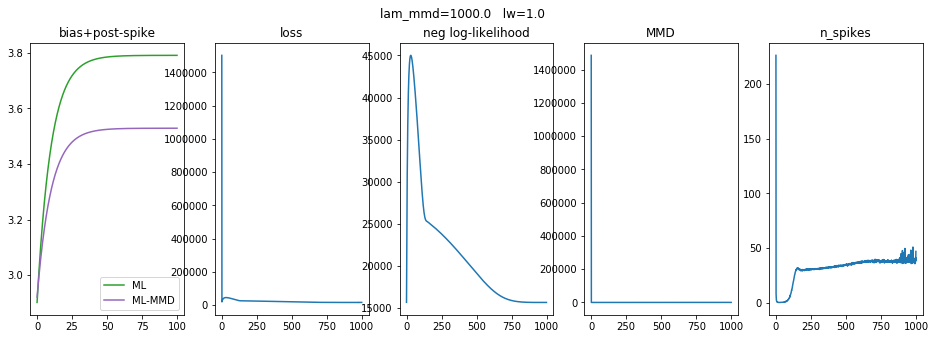

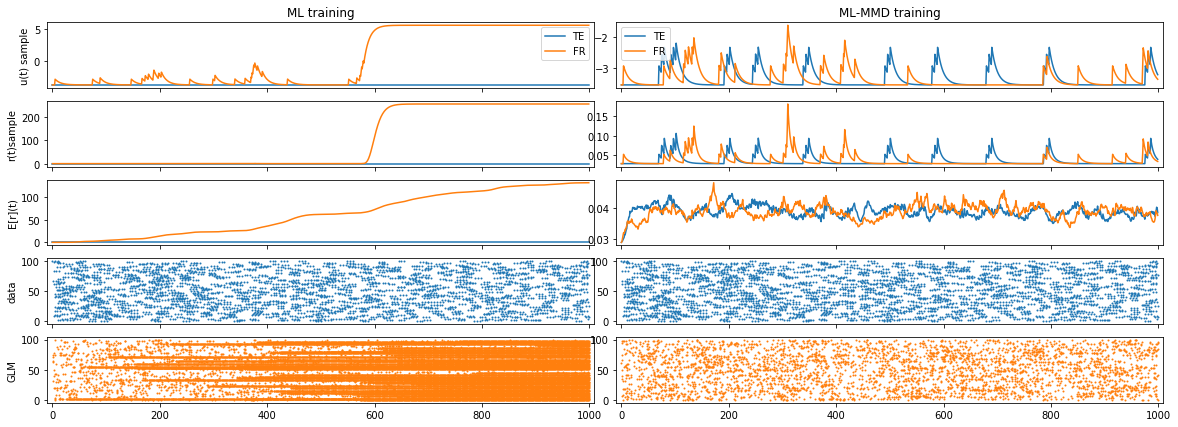

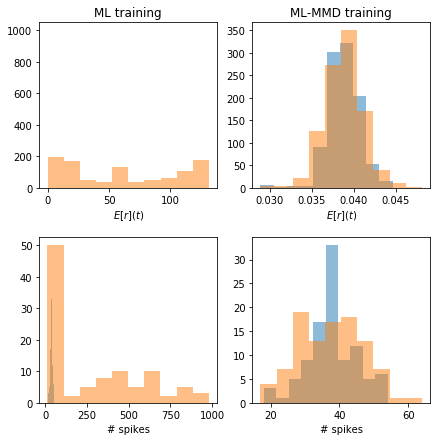

In [14]:
# lam_mmd, num_epochs, lr = 1e-1, 1000, 1e-1 # PERFECT FIT USING identity as feature ||E[lam_s] - E[lam_u]||
# lam_mmd, num_epochs, lr, non_linearity = 1e-1, 500, 1e-1, 'exp' #
lam_mmd, num_epochs, lr, non_linearity = 1e3, 1000, 1e0, 'log_exp' #

# eta_ml = KernelFun.exponential(tau=np.array([2, 20]), coefs=eta_vals_ml.copy())
eta_ml = KernelFun.exponential(tau=eta_tau.copy(), coefs=eta_vals_ml.copy())

wglm = MMDGLM(u0=float(u0_ml), eta=eta_ml.copy(), non_linearity=non_linearity)
# wglm = MMDGLM(u0=float(3.6), eta=KernelFun.exponential(tau=eta_tau.copy(), coefs=[0]))

loss, mmd, n_spikes = wglm.train(t, mask_spikes_te, y, distance, lam_mmd=lam_mmd, lr=lr, num_epochs=num_epochs, 
                                 n_batch_fr=n_batch_fr, verbose=True, mmd_kwargs=dict(sd=1e10))
loss, mmd, n_spikes = np.array(loss), np.array(mmd), np.array(n_spikes)

u_new_fr, r_new_fr, mask_spikes_new_fr = wglm.sample(t, shape=(n_batch_fr,))
u_new_te, r_new_te = wglm.sample_conditioned(t, mask_spikes_te)

mask_spikes_new = np.concatenate((mask_spikes_te, mask_spikes_new_fr), axis=1)
n_spikes_new_fr = np.sum(mask_spikes_new_fr, 0)
mask_spikes_new = torch.from_numpy(mask_spikes_new).double()
u_new = torch.from_numpy(np.concatenate((u_new_te, u_new_fr), axis=1)).double()
r_new = np.concatenate((r_new_te, r_new_fr), axis=1)
r_new = torch.from_numpy(r_new)

fig1, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(figsize=(16, 5), ncols=5)
fig1.suptitle('lam_mmd=' + str(lam_mmd) + '   lw=' + str(lr))
ti = np.arange(wglm.eta.support[0], wglm.eta.support[1], .1)
vals_ml = -eta_ml.interpolate(ti) - u0_ml
vals = -wglm.eta.interpolate(ti) - wglm.u0
ax0.plot(ti, vals_ml, color='C2', label='ML')
ax0.plot(ti, vals, color='C4', label='ML-MMD')
ax0.set_title('bias+post-spike')
ax0.legend()
ax1.plot(loss)
ax1.set_title('loss')
ax2.plot(loss - mmd)
ax2.set_title('neg log-likelihood')
ax3.plot(mmd)
ax3.set_title('MMD')
ax4.plot(n_spikes)
ax4.set_title('n_spikes')

fig2, ((ax00, ax01), (ax10, ax11), (ax20, ax21), (ax30, ax31), (ax40, ax41)) = plt.subplots(figsize=(20, 7), nrows=5, ncols=2, 
                                                                                           sharex=True, sharey=False)
fig2.subplots_adjust(wspace=0.04)

ax00.set_title('ML training')
ax00.plot(t, u_te[:, 0], label='TE')
ax00.plot(t, u_fr[:, 0], label='FR')
ax00.legend()
ax10.plot(t, r_te[:, 0])
ax10.plot(t, r_fr[:, 0])
ax20.plot(t, np.mean(r_te, 1))
ax20.plot(t, np.mean(r_fr, 1))
SpikeTrain(t, mask_spikes_te.numpy()).plot(ax=ax30, ms=ms, color='C0')
SpikeTrain(t, mask_spikes_fr).plot(ax=ax40, ms=ms, color='C1')
ax00.set_ylabel('u(t) sample')
ax10.set_ylabel('r(t)sample')
ax20.set_ylabel('E[r](t)')
ax30.set_ylabel('data')
ax40.set_ylabel('GLM')

ax01.set_title('ML-MMD training')
ax01.plot(t, u_new_te[:, 0], label='TE')
ax01.plot(t, u_new_fr[:, 0], label='FR')
ax01.legend()
ax11.plot(t, r_new_te[:, 0])
ax11.plot(t, r_new_fr[:, 0])
ax21.plot(t, np.mean(r_new_te, 1))
ax21.plot(t, np.mean(r_new_fr, 1))
SpikeTrain(t, mask_spikes_te.numpy()).plot(ax=ax31, ms=ms, color='C0')
SpikeTrain(t, mask_spikes_new_fr).plot(ax=ax41, ms=ms, color='C1')

fig3, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
fig3.subplots_adjust(hspace=0.3)
ax1.hist(torch.mean(r[:, y == 1], 1), alpha=0.5)
ax1.hist(torch.mean(r[:, y == 0], 1), alpha=0.5)
ax2.hist(torch.mean(r_new[:, y == 1], 1), alpha=0.5)
ax2.hist(torch.mean(r_new[:, y == 0], 1), alpha=0.5)

ax3.hist(n_spikes_te, alpha=0.5)
ax3.hist(n_spikes_fr, alpha=0.5)
ax4.hist(n_spikes_te, alpha=0.5)
ax4.hist(n_spikes_new_fr, alpha=0.5)

ax1.set_title('ML training')
ax2.set_title('ML-MMD training')
ax1.set_xlabel('$E[r](t)$') 
ax2.set_xlabel('$E[r](t)$')
ax3.set_xlabel('# spikes')
ax4.set_xlabel('# spikes')

In [46]:
import os
name = '/home/diego/Dropbox/generative_glm/figures/mmd_divergent_fr_fit_' + str(lam_mmd) + '_' + str(num_epochs)
fig1.savefig(name + '1.pdf', transparent=True)
fig2.savefig(name + '2.pdf', transparent=True)
fig3.savefig(name + '3.pdf', transparent=True)
os.system('pdfunite ' + name + '*.pdf ' + name + '.pdf')

0

In [40]:
os.system('pdfunite ' + name + '*.pdf ' + name + '.pdf')

0

In [38]:
'pdfunite ' + name + '*.pdf ' + name + '.pdf'

'pdfunite /home/diego/Dropbox/generative_glm/figures/mmd_divergent_fr_fit_0.1*.pdf /home/diego/Dropbox/generative_glm/figures/mmd_divergent_fr_fit_0.1.pdf'

(0.004517, 0.004518)

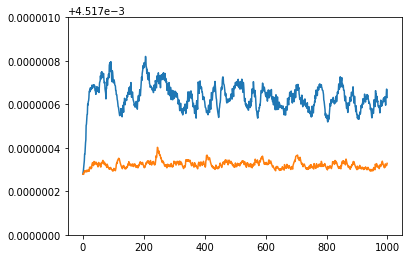

In [38]:
plt.plot(t, np.mean(r_new_te, 1))
plt.plot(t, np.mean(r_new_fr, 1))
plt.ylim(4.517e-3, 4.518e-3)

In [29]:
np.max(r_new_te)

0.004520379645401455

(array([241., 347., 163.,  95.,  55.,  50.,  20.,  20.,   6.,   3.]),
 array([0.01248375, 0.01402818, 0.01557262, 0.01711705, 0.01866149,
        0.02020592, 0.02175036, 0.02329479, 0.02483923, 0.02638366,
        0.0279281 ]),
 <a list of 10 Patch objects>)

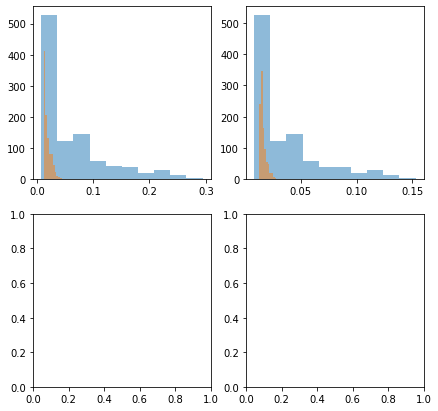

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
ax1.hist(torch.mean(r[:, y == 1], 1), alpha=0.5)
ax1.hist(torch.mean(r[:, y == 0], 1), alpha=0.5)
ax2.hist(torch.mean(r_new[:, y == 1], 1), alpha=0.5)
ax2.hist(torch.mean(r_new[:, y == 0], 1), alpha=0.5)
# ax1.hist(output0[y == 0], alpha=0.5)
# ax2.hist(output[y == 1], alpha=0.5)
# ax2.hist(output[y == 0], alpha=0.5)

In [20]:
r.shape

torch.Size([1000, 200])